# NOTEBOOK FOR THE ANALYSIS OF SINGLE-CELL RNA-SEQUENCING DATA FROM BT084

In [1]:
import numpy as np
import pandas as pd
import scanpy as sc
import bbknn
import scrublet as scr
import pandas as pd

In [2]:
sc.settings.verbosity = 3             # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.settings.set_figure_params(dpi=80, facecolor='white')

In [3]:
results_file = '/icgc/dkfzlsdf/analysis/B260/projects/przybilm/medulloblastoma/scRNA_analysis/scanpy/BT084-PDX_scanpy.h5ad'  # the file that will store the analysis results

## READ IN THE DATA FOR BT084-PDX AND PERFORM DOUBLET REMOVAL WITH SCRUBLET

In [4]:
adata_bt084 = sc.read_10x_mtx(
    '/icgc/dkfzlsdf/analysis/B260/projects/chromothripsis_medulloblastoma/data/10XRNA5P/BT084/BT084-PDX/outs/filtered_feature_bc_matrix/',  # the directory with the `.mtx` file
    var_names='gene_symbols',                # use gene symbols for the variable names (variables-axis index)
    cache=True)                              # write a cache file for faster subsequent reading

adata_bt084.var_names_make_unique()
adata_bt084

# make some metadata
adata_bt084.obs['sample'] = "BT084"
adata_bt084.obs['technology'] = "PDX"
adata_bt084.obs['patient'] = "BT084"

... reading from cache file cache/icgc-dkfzlsdf-analysis-B260-projects-chromothripsis_medulloblastoma-data-10XRNA5P-BT084-BT084-PDX-outs-filtered_feature_bc_matrix-matrix.h5ad


/home/przybilm/.local/lib/python3.7/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):


In [5]:
bt084_mouse_cells = pd.read_csv("/icgc/dkfzlsdf/analysis/B260/projects/chromothripsis_medulloblastoma/data/10XRNA5P/BT084/mm10_and_hg19/BT084.mapping.counts.txt", sep = '\t')
bt084_mouse_cells

,cell,count.hg19,count.mm10,total.count,ratio
0,AAACCTGAGTCAATAG-1,145,474,619,0.305907
1,AAACCTGGTGCACTTA-1,2726,6,2732,454.333333
2,AAACCTGGTTAAAGAC-1,16046,27,16073,594.296296
3,AAACCTGTCAGAGACG-1,173,553,726,0.312839
4,AAACGGGCACGGATAG-1,10250,211,10461,48.578199
...,...,...,...,...,...
1590,TTTGGTTAGCGAAGGG-1,89,445,534,0.200000
1591,TTTGGTTAGGAGTTTA-1,218,909,1127,0.239824
1592,TTTGTCAAGGCACATG-1,331,404,735,0.819307
1593,TTTGTCACATGCCTAA-1,18940,18,18958,1052.222222


In [6]:
bt084_mouse_cells = bt084_mouse_cells[bt084_mouse_cells['ratio'] > 1]
bt084_mouse_cells

,cell,count.hg19,count.mm10,total.count,ratio
1,AAACCTGGTGCACTTA-1,2726,6,2732,454.333333
2,AAACCTGGTTAAAGAC-1,16046,27,16073,594.296296
4,AAACGGGCACGGATAG-1,10250,211,10461,48.578199
8,AAAGCAACATGGTCAT-1,5656,216,5872,26.185185
9,AAAGTAGAGTCGCCGT-1,5418,35,5453,154.800000
...,...,...,...,...,...
1578,TTTACTGTCCTATTCA-1,290,217,507,1.336406
1579,TTTACTGTCGGCTACG-1,12043,11,12054,1094.818182
1583,TTTCCTCGTAAGTAGT-1,26572,61,26633,435.606557
1593,TTTGTCACATGCCTAA-1,18940,18,18958,1052.222222


In [7]:
bt084_mouse_cells_barcodes = bt084_mouse_cells['cell']
bt084_mouse_cells_barcodes 

1       AAACCTGGTGCACTTA-1
2       AAACCTGGTTAAAGAC-1
4       AAACGGGCACGGATAG-1
8       AAAGCAACATGGTCAT-1
9       AAAGTAGAGTCGCCGT-1
               ...        
1578    TTTACTGTCCTATTCA-1
1579    TTTACTGTCGGCTACG-1
1583    TTTCCTCGTAAGTAGT-1
1593    TTTGTCACATGCCTAA-1
1594    TTTGTCACATTACCTT-1
Name: cell, Length: 723, dtype: object

In [8]:
adata = adata_bt084[adata_bt084.obs_names.isin(bt084_mouse_cells_barcodes),:]

/home/przybilm/.local/lib/python3.7/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):


In [9]:
adata.obs

,sample,technology,patient
AAACCTGGTGCACTTA-1,BT084,PDX,BT084
AAACCTGGTTAAAGAC-1,BT084,PDX,BT084
AAACGGGCACGGATAG-1,BT084,PDX,BT084
AAAGCAACATGGTCAT-1,BT084,PDX,BT084
AAAGTAGAGTCGCCGT-1,BT084,PDX,BT084
...,...,...,...
TTGTAGGCACTACAGT-1,BT084,PDX,BT084
TTTACTGTCGGCTACG-1,BT084,PDX,BT084
TTTCCTCGTAAGTAGT-1,BT084,PDX,BT084
TTTGTCACATGCCTAA-1,BT084,PDX,BT084


In [10]:
scrub = scr.Scrublet(adata.X, expected_doublet_rate=0.06)

In [11]:
doublet_scores, predicted_doublets = scrub.scrub_doublets(min_counts=2, 
                                                          min_cells=3, 
                                                          min_gene_variability_pctl=85, 
                                                          n_prin_comps=30)

Preprocessing...
Simulating doublets...
Embedding transcriptomes using PCA...
Calculating doublet scores...
Automatically set threshold at doublet score = 0.30
Detected doublet rate = 1.8%
Estimated detectable doublet fraction = 2.4%
Overall doublet rate:
	Expected   = 6.0%
	Estimated  = 72.7%
Elapsed time: 0.8 seconds


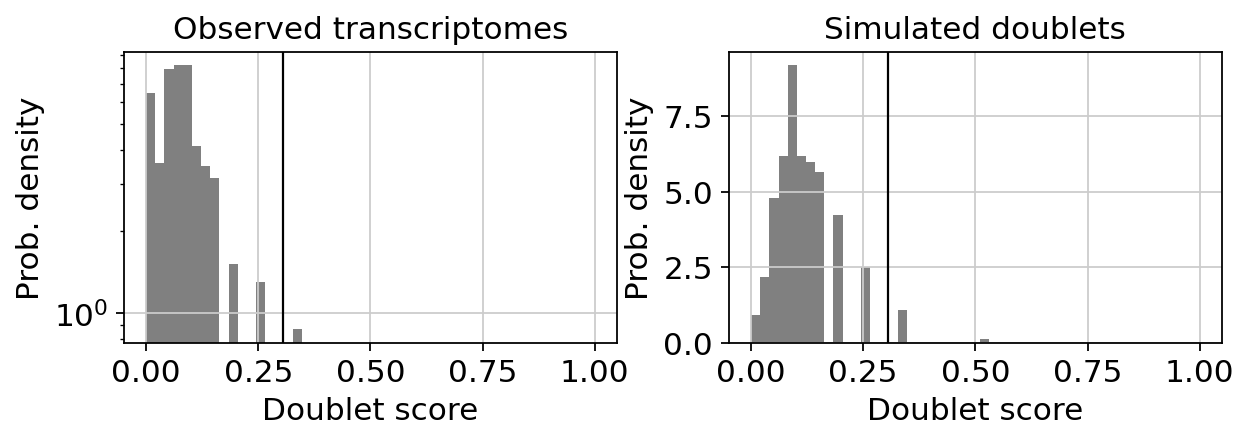

In [12]:
scrub.plot_histogram();

## START PERFORMING THE INITIAL QUALITY CONTROL

normalizing counts per cell
    finished (0:00:00)


/home/przybilm/.local/lib/python3.7/site-packages/scanpy/preprocessing/_normalization.py:155: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)


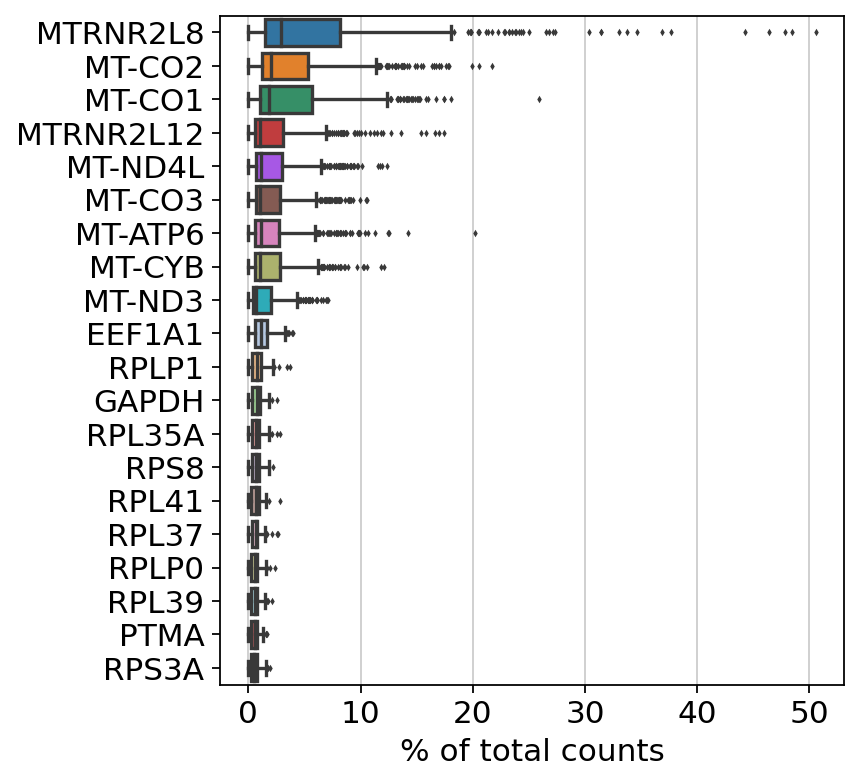

In [13]:
# preprocessing
sc.pl.highest_expr_genes(adata, n_top=20,)

In [14]:
# basic filtering
sc.pp.filter_cells(adata, min_genes=200)
sc.pp.filter_genes(adata, min_cells=3)

filtered out 45 cells that have less than 200 genes expressed
filtered out 20181 genes that are detected in less than 3 cells


/home/przybilm/.local/lib/python3.7/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):


In [15]:
# calculate some quality metrics as for instance mitochondrial percentage
adata.var['mt'] = adata.var_names.str.startswith('MT-')  # annotate the group of mitochondrial genes as 'mt'
sc.pp.calculate_qc_metrics(adata, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)

# and for ribosomal genes
adata.var['ribo'] = adata.var_names.str.startswith(('RPS','RPL'))  # annotate the group of ribosomal genes as 'ribo'
sc.pp.calculate_qc_metrics(adata, qc_vars=['ribo'], percent_top=None, log1p=False, inplace=True)

/home/przybilm/.local/lib/python3.7/site-packages/anndata/_core/anndata.py:1192: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if is_string_dtype(df[key]) and not is_categorical(df[key])
... storing 'sample' as categorical
... storing 'technology' as categorical
... storing 'patient' as categorical
... storing 'feature_types' as categorical


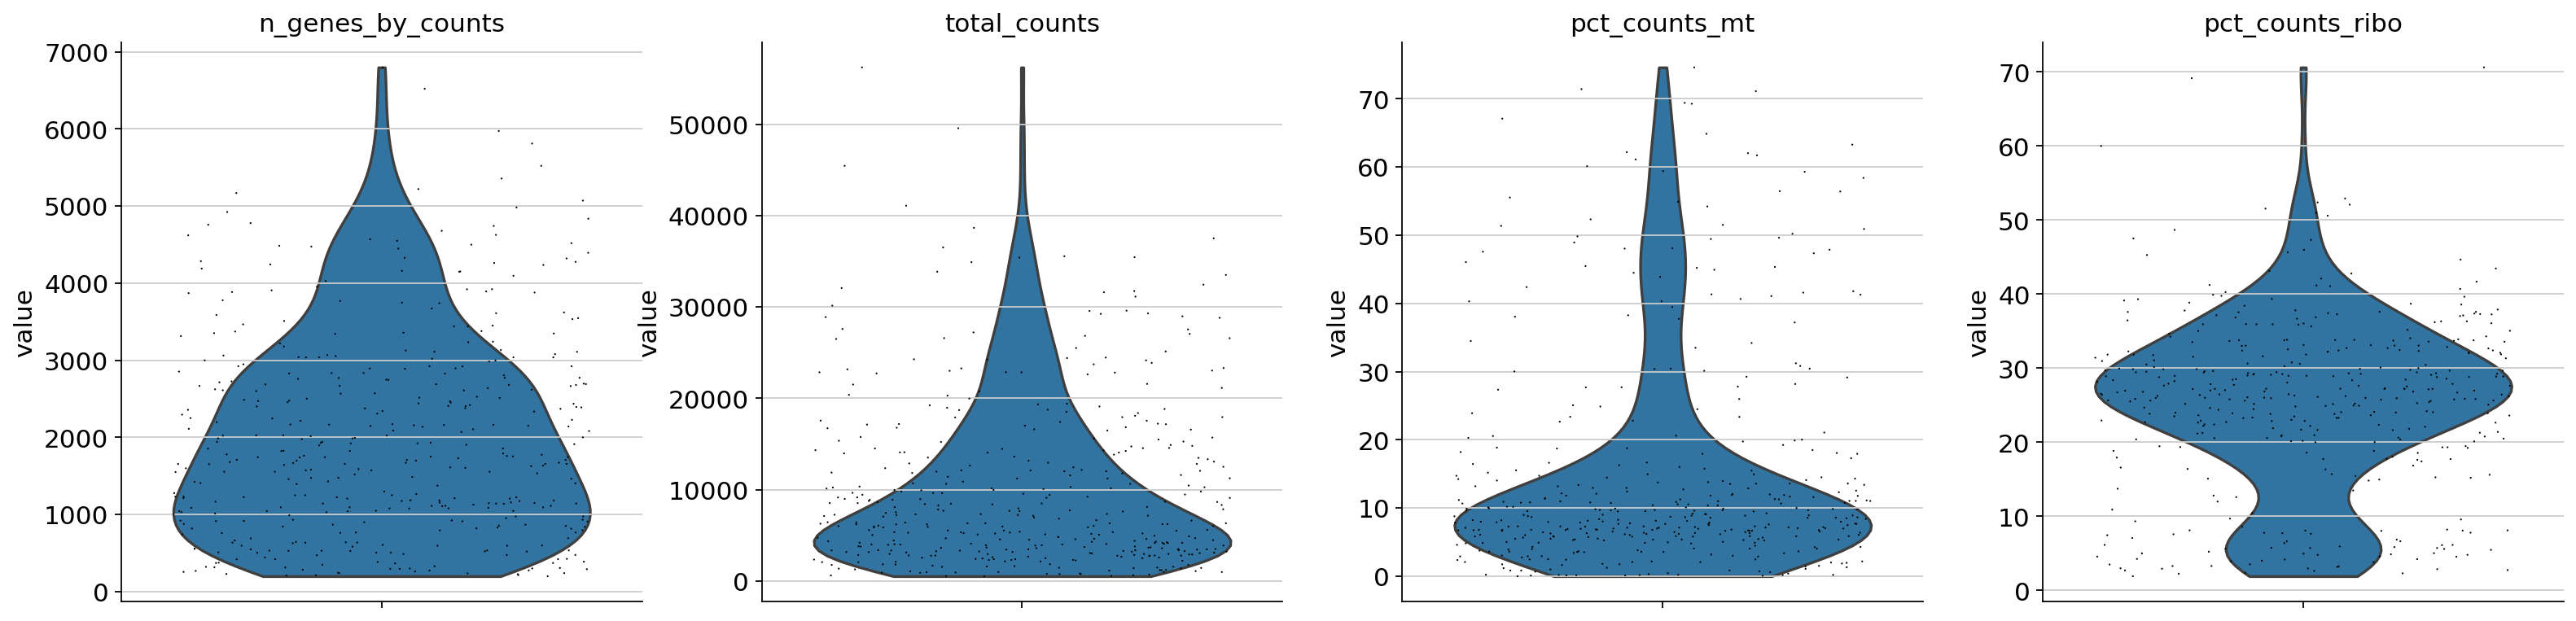

In [16]:
# visualize some QC metrics
sc.pl.violin(adata, ['n_genes_by_counts', 'total_counts', 'pct_counts_mt', 'pct_counts_ribo'],
             jitter=0.4, multi_panel=True)

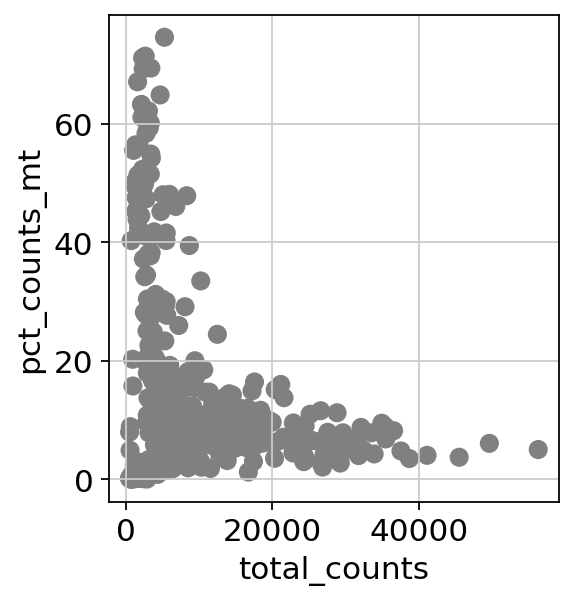

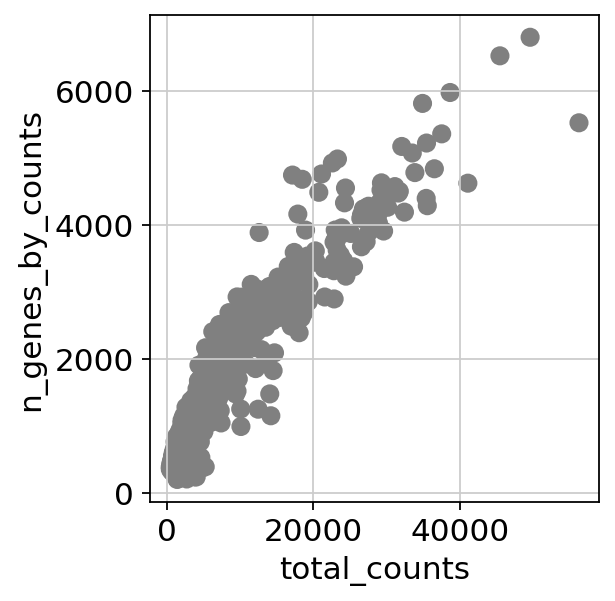

In [17]:
sc.pl.scatter(adata, x='total_counts', y='pct_counts_mt')
sc.pl.scatter(adata, x='total_counts', y='n_genes_by_counts')

In [18]:
# do the actual filtering by slicing the object
adata = adata[200 < adata.obs.n_genes_by_counts, :]
adata = adata[500 < adata.obs.total_counts, :]
adata = adata[adata.obs.total_counts < 25000, :]
adata = adata[adata.obs.pct_counts_mt < 10, :]
adata = adata[adata.obs.pct_counts_ribo < 40, :]

/home/przybilm/.local/lib/python3.7/site-packages/pandas/core/arrays/categorical.py:2630: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


In [19]:
adata

View of AnnData object with n_obs × n_vars = 182 × 12557
    obs: 'sample', 'technology', 'patient', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo'
    var: 'gene_ids', 'feature_types', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'ribo'

In [20]:
# calculate mean number of genes detected
mean_genes = adata.obs['n_genes'].mean()
print(mean_genes)

# calculate mean number of transcripts detected
mean_counts = adata.obs['total_counts'].mean()
print(mean_counts)

2232.313186813187
10113.8134765625


## PERFORM NORMALIZATION, PCA AND CLUSTERING

In [21]:
sc.pp.normalize_total(adata, target_sum=1e4)

normalizing counts per cell
    finished (0:00:00)


/home/przybilm/.local/lib/python3.7/site-packages/scanpy/preprocessing/_normalization.py:155: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)


In [22]:
sc.pp.log1p(adata)

In [23]:
sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5)

extracting highly variable genes
    finished (0:00:00)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


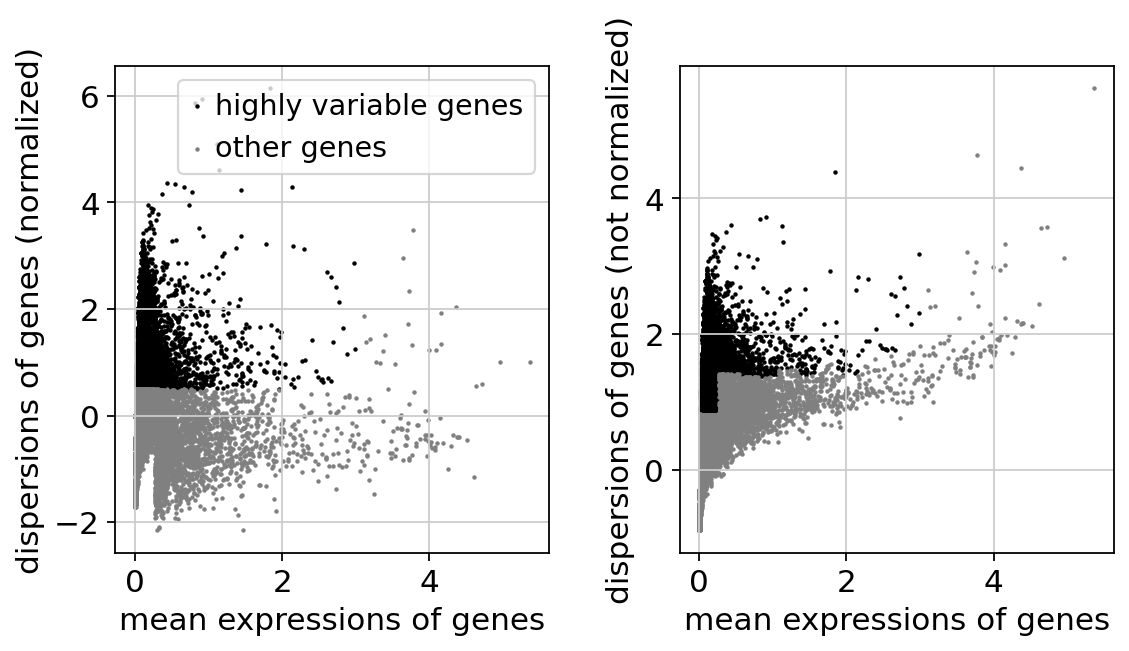

In [24]:
sc.pl.highly_variable_genes(adata)

In [25]:
# set the raw attribute of anndata
adata.raw = adata

In [26]:
adata = adata[:, adata.var.highly_variable]

In [27]:
# regress out effects of total counts per cell and the percentage of mitochondrial genes
sc.pp.regress_out(adata, ['total_counts', 'pct_counts_mt', 'pct_counts_ribo'])

regressing out ['total_counts', 'pct_counts_mt', 'pct_counts_ribo']
    sparse input is densified and may lead to high memory use
    finished (0:00:06)


In [28]:
sc.pp.scale(adata, max_value=10)
sc.tl.pca(adata, svd_solver='arpack')

computing PCA
    on highly variable genes
    with n_comps=50
    finished (0:00:00)


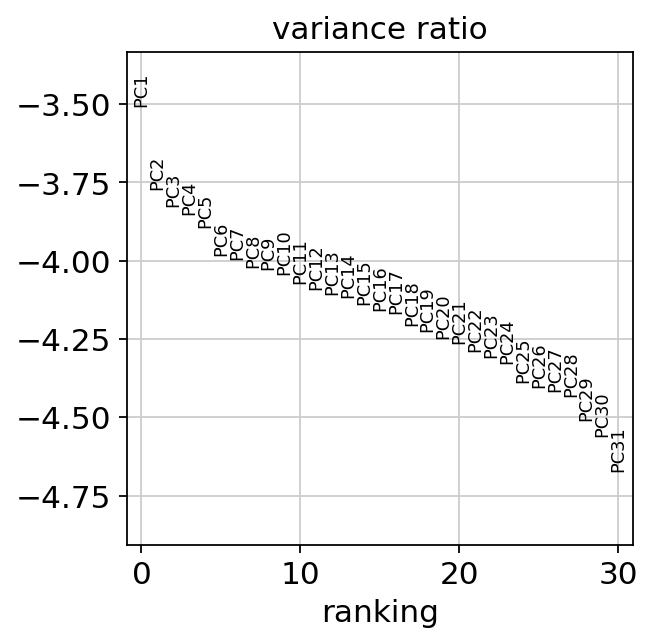

In [29]:
sc.pl.pca_variance_ratio(adata, log=True)

In [30]:
# compute nearest neighbors, UMAP and clustering
sc.pp.neighbors(adata, n_neighbors=10, n_pcs=5)
sc.tl.umap(adata, n_components=2, min_dist=0.1,  # Scanpy default = 0.05
           spread=1.0, copy=False, random_state=0)
sc.tl.louvain(adata, resolution= 0.2)
sc.tl.leiden(adata, resolution= 0.2)

computing neighbors
    using 'X_pca' with n_pcs = 5
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:02)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:01)
running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished: found 2 clusters and added
    'louvain', the cluster labels (adata.obs, categorical) (0:00:00)
running Leiden clustering
    finished: found 2 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:00)


/home/przybilm/.local/lib/python3.7/site-packages/anndata/_core/anndata.py:1192: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if is_string_dtype(df[key]) and not is_categorical(df[key])


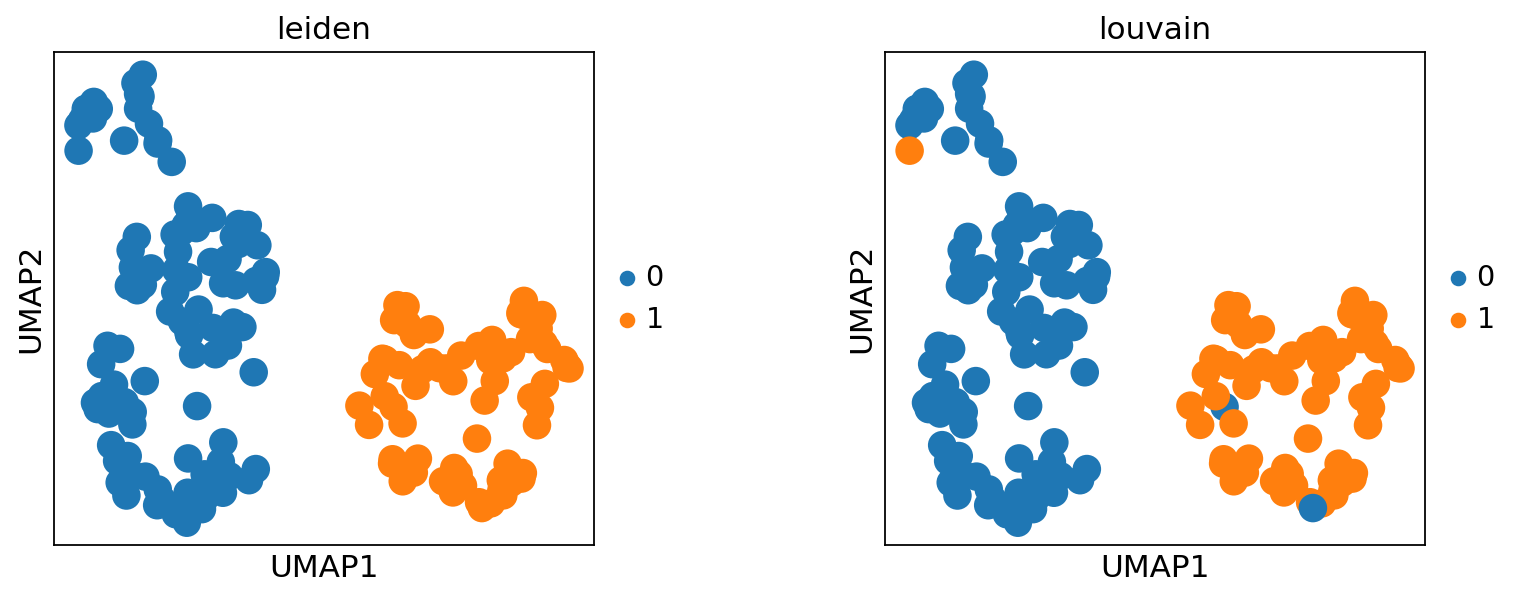

In [31]:
sc.pl.umap(adata, color=['leiden', 'louvain'], save = '_BT084-PDX.pdf', wspace = 0.4)

ranking genes


/home/przybilm/.local/lib/python3.7/site-packages/anndata/_core/anndata.py:1192: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if is_string_dtype(df[key]) and not is_categorical(df[key])


    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:00)


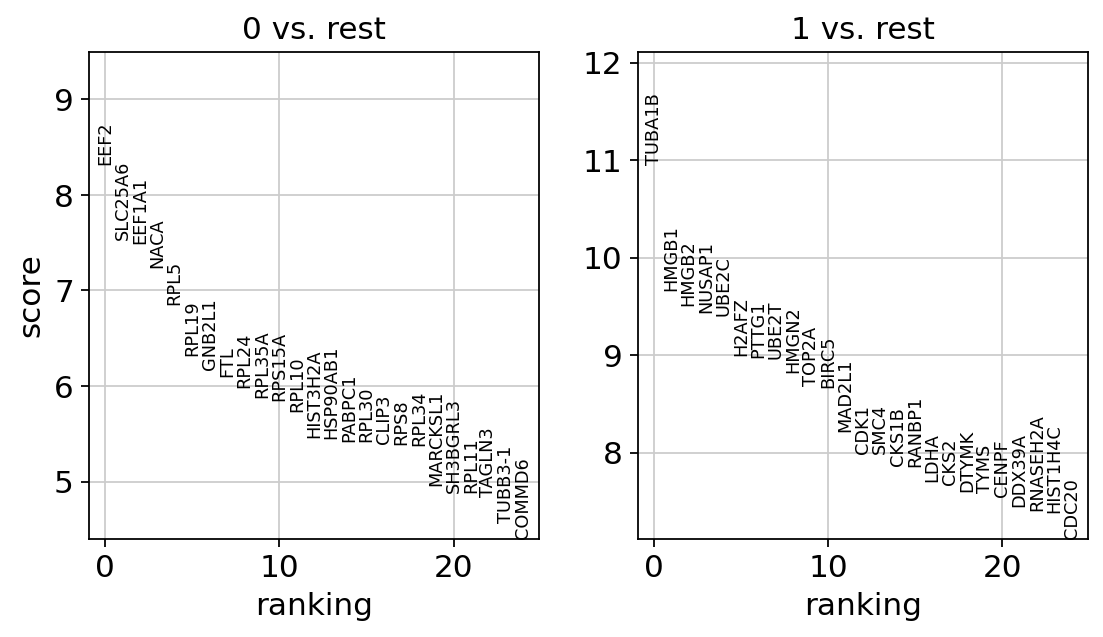

In [32]:
# find marker genes for each cluster using the Wilcoxon rank sum test
sc.tl.rank_genes_groups(adata, 'leiden', method='wilcoxon')
sc.pl.rank_genes_groups(adata, n_genes=25, sharey=False, save = "_BT084-PDX_leiden.pdf")

In [33]:
pd.DataFrame(adata.uns['rank_genes_groups']['names']).head(5)

,0,1
0,EEF2,TUBA1B
1,SLC25A6,HMGB1
2,EEF1A1,HMGB2
3,NACA,NUSAP1
4,RPL5,UBE2C


In [34]:
result = adata.uns['rank_genes_groups']
groups = result['names'].dtype.names
wilcoxon_df = pd.DataFrame(
    {group + '_' + key[:1]: result[key][group]
    for group in groups for key in ['names', "scores", 'logfoldchanges', "pvals", 'pvals_adj']})

In [35]:
wilcoxon_df.to_csv("/omics/groups/OE0540/internal/projects/przybilm/medulloblastoma/revision/scrna_analysis/scanpy/BT084-PDX_DEG_wilcoxon.csv")

In [ ]:
new_cluster_names = ['cluster0', 'cluster1']
adata.rename_categories('leiden', new_cluster_names)

old_to_new = dict(
    cluster0='malignant ribosomal',
    cluster1='malignant cycling'
)

adata.obs['new_clusters'] = (
    adata.obs['leiden']
    .map(old_to_new)
    .astype('category')
)

In [ ]:
sc.pl.umap(adata, color=['new_clusters'], save = '_BT084-PDX_CellType.pdf', wspace = 0.6, legend_fontsize = 6)

In [ ]:
adata.write("/omics/groups/OE0540/internal/projects/przybilm/medulloblastoma/revision/scrna_analysis/scanpy/BT084-PDX_Celltype_scanpy.h5ad")

In [ ]:
metadata = pd.DataFrame(adata.obs, index=adata.obs_names)
metadata.to_csv('/omics/groups/OE0540/internal/projects/przybilm/medulloblastoma/revision/scrna_analysis/scanpy/BT084-PDX_metadata.csv')

In [ ]:
sc.pl.umap(adata, color=['new_clusters'], save = '_BT084-PDX_CellType_only.pdf', wspace = 0.6, legend_fontsize = 6)

In [ ]:
sc.pl.umap(adata, color=['GLI2'], wspace = 0.5, save = '_BT084-PDX_GLI2_marker_visualization.pdf')

In [ ]:
# rcParams['figure.figsize'] = 4.5,3
sc.pl.violin(adata, ['GLI2'], groupby='sample', save = '_BT084-PDX_GLI2_marker_visualization.pdf')

## PROJECT CHROMOTHRIPSIS SIGNATURE ONTO THE EMBEDDING

In [3]:
adata = sc.read("/omics/groups/OE0540/internal/projects/przybilm/medulloblastoma/revision/scrna_analysis/scanpy/BT084-PDX_Celltype_scanpy.h5ad")

In [4]:
f="/icgc/dkfzlsdf/analysis/B260/projects/przybilm/medulloblastoma/scRNA_analysis/MB_shh_filtered_table_FDR.tsv"
pos_df=pd.read_table(f, sep='\t')
pos_df=pos_df.loc[pos_df['log2FoldChange'] > 0,:]
pos_df=pos_df.loc[pos_df['padj'] <= 0.05,:]
neg_df=pd.read_table(f, sep='\t')
neg_df=neg_df.loc[neg_df['log2FoldChange'] < 0,:]
neg_df=neg_df.loc[neg_df['padj'] <= 0.05,:]

In [5]:
pos_df
neg_df

,ens_fullid,ens_id,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj,gene_name
409,ENSG00000187097.12_3,ENSG00000187097,1662.242563,-0.359350,0.109875,-3.270523,1.073486e-03,0.036798,ENTPD5
410,ENSG00000250462.8_2,ENSG00000250462,1332.612360,-0.407023,0.128259,-3.173454,1.506366e-03,0.045176,LRRC37BP1
411,ENSG00000076242.14_2,ENSG00000076242,4657.937488,-0.414492,0.112141,-3.696177,2.188700e-04,0.013763,MLH1
412,ENSG00000113812.13_3,ENSG00000113812,6868.479447,-0.436607,0.127945,-3.412451,6.438160e-04,0.026346,ACTR8
413,ENSG00000100890.15_3,ENSG00000100890,808.125224,-0.443807,0.140809,-3.151842,1.622438e-03,0.047158,KIAA0391
...,...,...,...,...,...,...,...,...,...
1042,ENSG00000237869.2,ENSG00000237869,12.804303,-5.767545,1.786001,-3.229307,1.240907e-03,0.040182,RP11-459O16.1
1043,ENSG00000183072.9_2,ENSG00000183072,260.545238,-5.943601,1.123514,-5.290188,1.220000e-07,0.000112,NKX2-5
1044,ENSG00000266736.1_2,ENSG00000266736,102.835417,-6.129589,1.766502,-3.469902,5.206490e-04,0.023260,RP11-260A9.4
1045,ENSG00000253226.1_2,ENSG00000253226,23.377382,-6.273874,1.701660,-3.686913,2.269910e-04,0.014047,HAUS1P3


In [6]:
gene_list_pos=pos_df['gene_name']
intersect_gene_list_pos=adata.var_names.isin(list(gene_list_pos))
gene_list_pos=adata.var_names[intersect_gene_list_pos]

In [7]:
len(gene_list_pos)

63

In [8]:
gene_list_neg=neg_df['gene_name']
intersect_gene_list_neg=adata.var_names.isin(list(gene_list_neg))
gene_list_neg=adata.var_names[intersect_gene_list_neg]

In [9]:
len(gene_list_neg)

45

In [10]:
sc.tl.score_genes(adata, list(gene_list_pos), ctrl_size=len(gene_list_pos), gene_pool=None, n_bins=25, score_name='Upregulated_Chromothripsis_Score', random_state=0, copy=False, use_raw=None)
sc.tl.score_genes(adata, list(gene_list_neg), ctrl_size=len(gene_list_neg), gene_pool=None, n_bins=25, score_name='Downregulated_Chromothripsis_Score', random_state=0, copy=False, use_raw=None)

computing score 'Upregulated_Chromothripsis_Score'
    finished: added
    'Upregulated_Chromothripsis_Score', score of gene set (adata.obs).
    1356 total control genes are used. (0:00:00)
computing score 'Downregulated_Chromothripsis_Score'
    finished: added
    'Downregulated_Chromothripsis_Score', score of gene set (adata.obs).
    934 total control genes are used. (0:00:00)


/home/przybilm/.local/lib/python3.7/site-packages/anndata/_core/anndata.py:1192: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if is_string_dtype(df[key]) and not is_categorical(df[key])


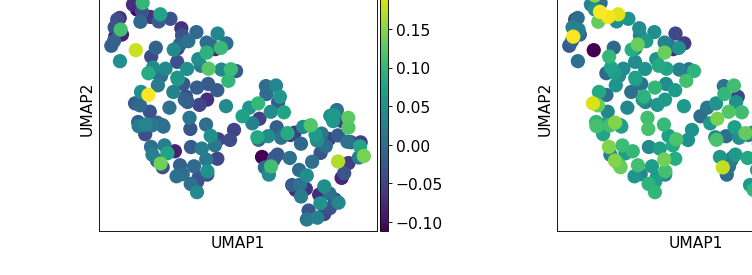

In [11]:
sc.pl.umap(adata, color=['Upregulated_Chromothripsis_Score', 'Downregulated_Chromothripsis_Score'], save = '_BT084-PDX_chromothripsisScore.pdf', wspace = 0.5)

In [12]:
# assign the column with the cell_type id in the metadata of the annData object
metadata = pd.DataFrame(adata.obs, index=adata.obs_names)
metadata.to_csv('/icgc/dkfzlsdf/analysis/B260/projects/przybilm/medulloblastoma/infercnv_MB/scRNA_scDNA/BT084-PDX_chromothripsisScore_metadata.csv')